In [1]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.signal.windows import dpss
from nitime.algorithms.spectral import multi_taper_psd
from mne.time_frequency import psd_array_multitaper
from numpy.lib.stride_tricks import sliding_window_view

from specparam import SpectralModel

from utils.signal_processing import *
from utils.fpp_simulation import *
from utils.plotting import *

---
##### **Different types of kernels**
- Alpha functions, square pulses and dual exponentials.

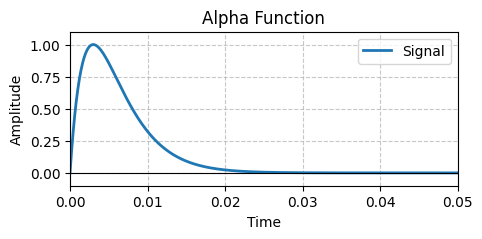

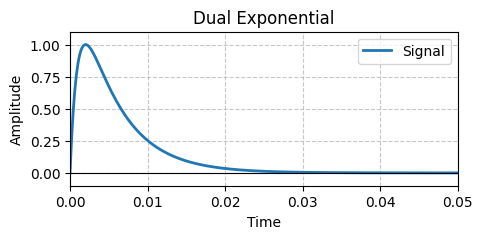

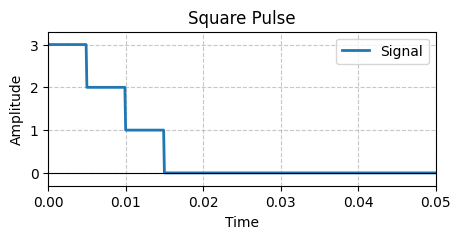

In [2]:
kernel_alpha, time_alpha = alpha_function(t_sec = 0.2,
                                          fs = 10000,
                                          tau_s = 3 / 1000, 
                                          max_amplitude = 1)

kernel_dexp, time_dexp = dual_exponential(t_sec = 0.2, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 5 / 1000, 
                                          max_amplitude = 1)

kernel_sq, time_sq = triple_square_kernel(t_sec = 0.2,
                                          fs = 10000, 
                                          t1_s = 5 /  1000, 
                                          t2_s = 10 / 1000,
                                          t3_s = 15 / 1000,
                                          amplitude1 = 3.0, 
                                          amplitude2 = 2.0, 
                                          amplitude3 = 1.0)

plot_trace(kernel_alpha, time_alpha, title = 'Alpha Function')
plot_trace(kernel_dexp, time_dexp, title = 'Dual Exponential')
plot_trace(kernel_sq, time_sq, title = 'Square Pulse')

---
##### **Simulating LFPs as a superposition of synaptic events**

In [3]:
kernel_dexp, time_dexp = dual_exponential(t_sec = 10, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

signal, time_signal, event_rate_s = simulate_fpp(kernel = kernel_dexp,
                                                 fs = 10000,
                                                 t_sec = 10, 
                                                 num_neurons = 5000, 
                                                 rate = 50)

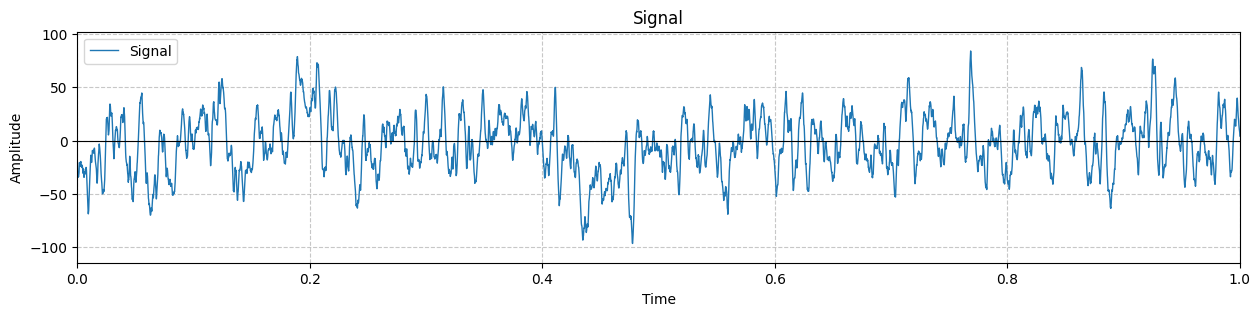

In [4]:
plot_trace(signal, time_signal, size = (15, 3), xlim = (0, 1), linewidth = 1)

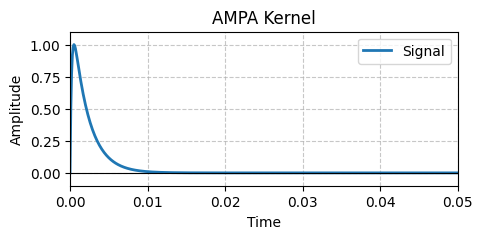

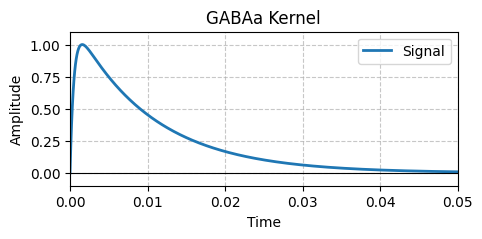

In [5]:
kernel_ampa, time_ampa = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

plot_trace(kernel_ampa, time_ampa, title = 'AMPA Kernel')
plot_trace(kernel_gaba, time_gaba, title = 'GABAa Kernel')

In [6]:
lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = 10000, 
                                                           t_sec = 1, 
                                                           n_ex = 5000, 
                                                           n_in = 5000, 
                                                           rate_ex = 50, 
                                                           rate_in = 50)

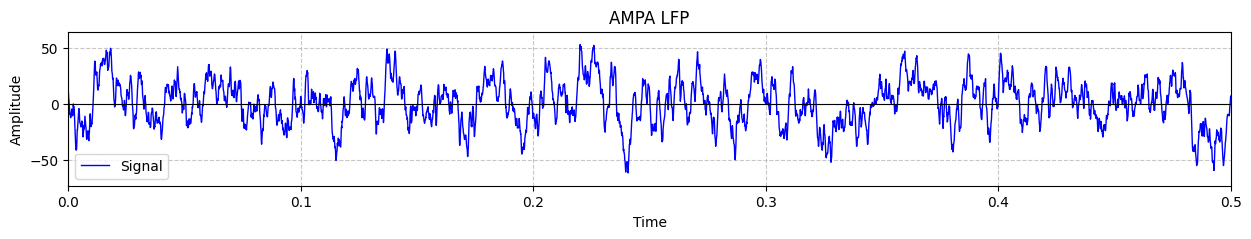

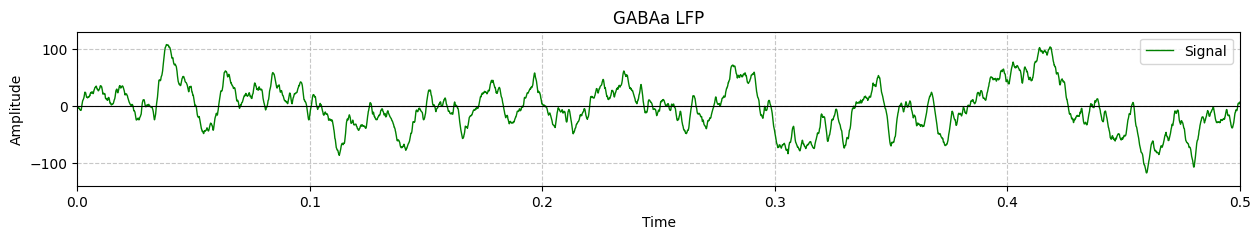

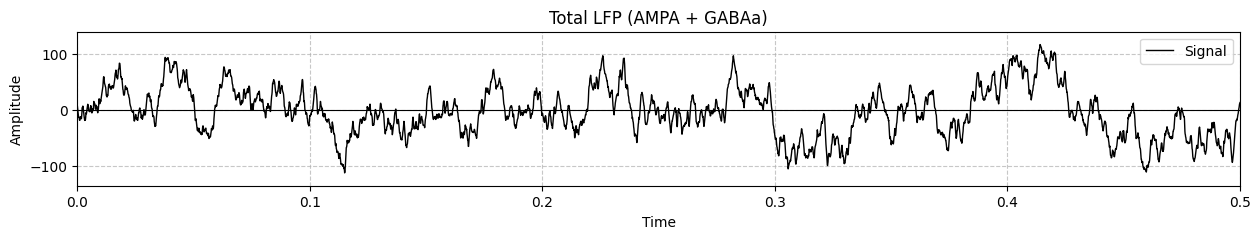

In [7]:
plot_trace(lfp_ex, time_lfp, title = 'AMPA LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'b', linewidth = 1)
plot_trace(lfp_in, time_lfp, title = 'GABAa LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'g', linewidth = 1)
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

---
##### **Describing signal dynamics**

In [29]:
# Signal parameters 
t_sec = 300
fs = 10000
window_sec = 2
overlap_sec = 1

# Synaptic parameters (pure AMPA signal)
n_ex = 5000
n_in = 5000
rate_ex = 50
rate_in = 0
w_ex = -1
w_in = 1

kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = fs, 
                                                           t_sec = t_sec, 
                                                           n_ex = n_ex, 
                                                           n_in = n_in, 
                                                           rate_ex = rate_ex, 
                                                           rate_in = rate_in,
                                                           w_ex = w_ex,
                                                           w_in = w_in)

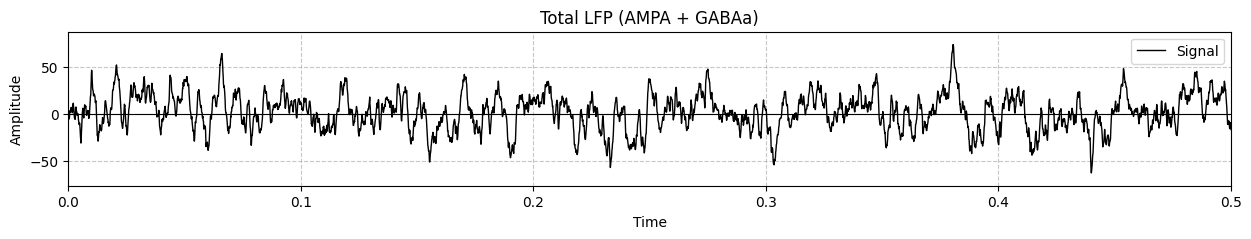

In [30]:
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

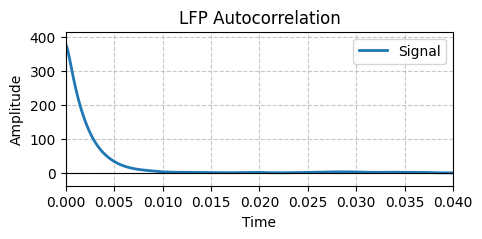

In [31]:
acf, time_acf = circular_autocorrelation(signal = lfp_total, fs = fs)
plot_trace(acf, time_acf, title = 'LFP Autocorrelation', xlim = (0, 0.04))

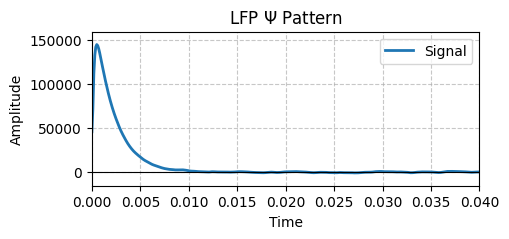

In [32]:
psi, time_psi = averaged_psi_pattern(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)
plot_trace(psi, time_psi, title = 'LFP $\Psi$ Pattern', xlim = (0, 0.04))

In [33]:
t_max, rise_time, decay_time, max_val = psi_params(psi = psi, time_lags = time_psi, verbose = True)

Rise Time: 0.5 ms
Decay Time: 4.1 ms
Total Duration: 4.6 ms


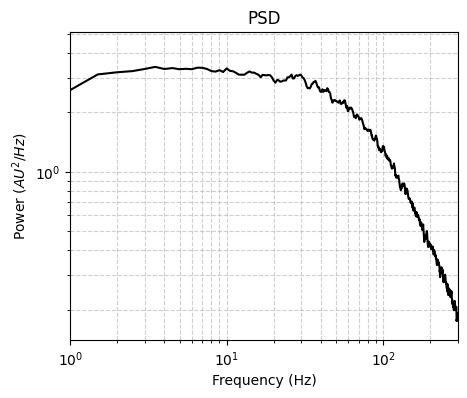

In [34]:
psd, freqs = averaged_multitaper_psd(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
plot_psd_log(psd = psd, freqs = freqs, xlim = (1, 300))

Aperiodic Params: [4.62076257e+00 9.69120369e-03 1.27425528e+04 2.13366038e+00]
Error: 0.012674178659355302
R2: 0.9983092304823646
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was fit with the 'spectral_fit' algorithm                        
              Model was fit to the 1-300 Hz frequency range with 0.50 Hz resolution               
                                                                                                  
                              Aperiodic Parameters ('doublexp' mode)                              
                               (offset, exponent0, knee, exponent1)                               
                                4.6208, 0.0097, 12742.5528, 2.1337           

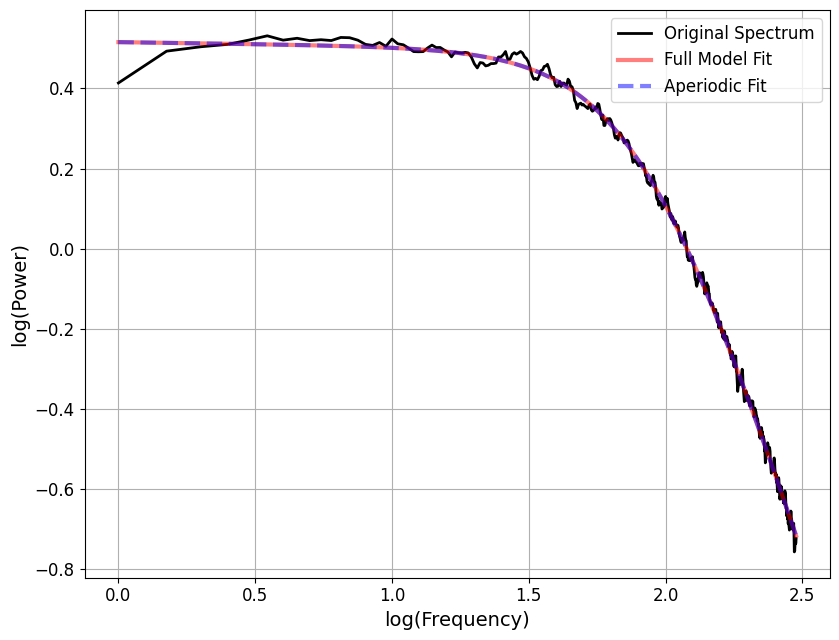

In [35]:
freq_range = [1, 300]
aperiodic_mode = 'doublexp'

model = specparam(psd = psd, freqs = freqs, freq_range = freq_range, aperiodic_mode = aperiodic_mode, verbose = True)
model.report(freqs, psd, freq_range, plt_log = True)